In [1]:
# This file is an implementation of the Spring Loaded Centroidal Env
# Author : Avadesh Meduri
# Date : 20/06/2020

import numpy as np

import IPython
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

from py_motion_planner.cent_motion_planner import CentMotionPlanner

In [86]:
'''
This is an implementation of an environment with Centroidal dynamics to train
dq steper for running. CentMotionPlanner generates trajectories with zero momentum
'''

class CentEnv:
    
    def __init__(self, h, b, max_step_length, w_cost, no_actions=[11,9]):
        '''
        Input:
            h : height of the com above the ground at the start of the step
            b : width of the base (distance between the feet)
            k : spting stiffness for each leg
            max_step_length : max step length allowed
            w_cost : weights for the cost computation
            no_actions : number of discretizations
        '''
        self.g = 9.81
        self.max_leg_length = 0.32
        self.mass = 1.27
        self.inertia = [0.016, 0.031, 0.031]
        self.com_offset = 0.078
        # nominal desired height above the foot location
        self.h = h
        self.b = b
        self.no_steps = 0
        self.max_step_ht = 0.1 # maximum step in z
        self.no_actions = no_actions
        assert len(w_cost) == 3
        self.w_cost = w_cost #wt in cost computations
        assert len(no_actions) == 2
        # The co ordinate axis is x : forward and y : sideways walking, z : faces upward
        # This means that left leg is on the positive side of the y axis
        # The addition b is added to accomodate a step length larger than leg length as it may be feasible
        # in high velocity cases.
        self.action_space_x = np.around(np.linspace(-max_step_length, max_step_length, no_actions[0]), 2)
        
        # actions to the free side
        if b > 0 :
            self.action_space_ly = np.geomspace(b, max_step_length + b, int(2*no_actions[1]/3))
            # actions to the non free side where leg can hit the other leg
            # Y axis actions step length allowed such that robot can't step to the left of the left leg
            # or the right to the right leg (no criss crossing)
            self.action_space_ry = np.linspace(0, b, int(no_actions[1]/3), endpoint = False)
            self.action_space_y = np.around(np.concatenate((self.action_space_ry, self.action_space_ly)), 2)
        else:
            self.action_space_y = np.around(np.linspace(0, max_step_length, int(no_actions[1])), 2)
        
        self.t = 0
        # motion planner params
        self.delta_t = 0.025
        self.f_max = np.array([[30,30, 30], [30, 30, 30]])
        self.max_ht = np.array([[0.4, 0.4, 0.4], [0.4, 0.4, 0.4]])
        self.w = np.array([1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e+2, 1e+2, 1e+7, 1e+7, 1e-4, 1e-4, 1e+1, 1e-4, 1e-4, 1e+1])
        self.ter_w = np.array([1e-4, 1e-4, 1e+8, 1e-4, 1e-4, 1e+5, 1e+3, 1e+3, 1e+6, 1e+6])
        self.xt = [0, 0, self.h, 0, 0, 0, 0, 0, 0, 0]
        self.cent_mp = CentMotionPlanner(self.delta_t, 2, self.mass, self.inertia, self.f_max, self.max_ht)
        
    def reset_env(self, x0, v_des, epi_time):
        '''
        This function resets the environment
        Input:
            x0 : starting state [x,y,z,xd,yd,zd]
            v_des : desired velocity of center of mass
            epi_time : episode time
        '''
        assert len(x0) == 6
        self.t = 0
        self.v_des = v_des
        self.sim_data = np.zeros((10 + 3 + 1, int(np.round(epi_time/self.delta_t,2))+1))
        self.sim_force = np.zeros((2, 3, int(np.round(epi_time/self.delta_t,2))))
        self.sim_data[:,self.t][0:6] = x0
        self.sim_data[:,self.t][11] = -self.b/2
        self.sim_data[:,self.t][13] = 1 # right leg on the ground
        
        processed_state = np.zeros(8)
        processed_state[0:6] = np.take(self.sim_data[:,self.t], [0, 1, 2, 3, 4, 13])
        processed_state[0:3] -= self.sim_data[:,self.t][10:13]
        processed_state[6:] = self.v_des    
        
        return processed_state
    
    def step_env(self, action, step_time, air_time):
        '''
        This function simulates the environment for one foot step
        Input:
            u : next step location
            step_time : duration of after which step is taken [ux_index, uy_index, uz (value)]
        '''
        assert len(action) == 3
        assert action[2] < self.max_step_ht

        self.xt[2] = self.sim_data[12, self.t] + action[2] + self.h
        horizon = 2*step_time + air_time
        cnt_plan = [[[0, 0, 0, 0, 0, step_time], [0, 0, 0, 0, 0, step_time]],
                    [[0, 0, 0, 0, step_time, step_time + air_time], [0, 0, 0, 0, step_time, step_time + air_time]],
                    [[0, 0, 0, 0, step_time + air_time, np.round(2*step_time + air_time,2)], [0, 0, 0, 0, step_time + air_time, np.round(2*step_time + air_time,2)]]]

        
        if self.sim_data[:,self.t][13] > 0:
            cnt_plan[0][1][0] = 1
            cnt_plan[0][1][1:4] = self.sim_data[:,self.t][10:13]
            cnt_plan[2][0][0] = 1
            cnt_plan[2][0][1] = self.sim_data[:,self.t][10] + self.action_space_x[action[0]]            
            cnt_plan[2][0][2] = self.sim_data[:,self.t][11] + self.sim_data[13, self.t]*self.action_space_y[action[1]]            
            cnt_plan[2][0][3] = self.sim_data[:,self.t][12] + self.sim_data[13, self.t]*action[2]            
        
        else:
            cnt_plan[0][0][0] = 1
            cnt_plan[0][0][1:4] = self.sim_data[:,self.t][10:13]
            cnt_plan[2][1][0] = 1
            cnt_plan[2][1][1] = self.sim_data[:,self.t][10] + self.action_space_x[action[0]]            
            cnt_plan[2][1][2] = self.sim_data[:,self.t][11] + self.sim_data[13, self.t]*self.action_space_y[action[1]]            
            cnt_plan[2][1][3] = self.sim_data[:,self.t][12] + self.sim_data[13, self.t]*action[2]            
        
        step_time = int(np.round(step_time/self.delta_t,2))
        air_time = int(np.round(air_time/self.delta_t,2))
        
        self.sim_data[0:10, self.t:self.t + 2*step_time + air_time + 1], _ = \
                self.cent_mp.optimize(self.sim_data[0:10, self.t], cnt_plan, self.xt, self.w, self.ter_w, horizon)
        
        self.sim_data[10:, self.t:self.t + step_time + 1] = np.tile([self.sim_data[:,self.t][10:]],(step_time+1,1)).T #u
        self.t += step_time + air_time + 1
        self.sim_data[10, self.t:self.t + step_time] = self.sim_data[10, self.t - air_time - 1] + self.action_space_x[action[0]]
        self.sim_data[11, self.t:self.t + step_time] = self.sim_data[11, self.t - air_time - 1] + self.sim_data[13, self.t - air_time]*self.action_space_y[action[1]]
        self.sim_data[12, self.t:self.t + step_time] = self.sim_data[12, self.t - air_time - 1] + action[2]
        self.sim_data[13, self.t:self.t + step_time] = -1*self.sim_data[13, self.t - air_time - 1]
        
        self.t += step_time - 1
    
        processed_state = np.zeros(8)
        processed_state[0:6] = np.take(self.sim_data[:,self.t], [0, 1, 2, 3, 4, 13])
        processed_state[0:3] -= self.sim_data[:,self.t][10:13]
        processed_state[6:] = self.v_des    
        
        if self.isdone(processed_state):
            self.sim_data = self.sim_data[:,0:self.t+1]
            self.sim_force = self.sim_force[:,0:self.t+1]
            
        return processed_state, self.compute_cost(processed_state, action), self.isdone(processed_state)
    
    def isdone(self, processed_state):
        '''
        This function checks if the kinematic constraints are violated
        '''
        leg_dist = processed_state[0:3].copy()
        leg_dist[2] -= self.com_offset
        if np.linalg.norm(leg_dist) > self.max_leg_length:
            return True
        elif leg_dist[2] < 0.05:
            return True
        else:
            return False
    
    def compute_cost(self, processed_state, action):
        '''
        This function computes the cost after the step is taken
        '''
        leg_length = processed_state.copy()
        leg_length[2] -= self.com_offset
        cost = self.w_cost[0]*(np.abs(leg_length[0]) + np.abs(leg_length[1]))
        if self.isdone(processed_state):
            cost += 100
            
        cost += self.w_cost[1]*(np.abs(self.sim_data[:,self.t][3] - self.v_des[0]) + np.abs(self.sim_data[:,self.t][4] - self.v_des[1]))
        
        cost += self.w_cost[2]*(np.abs(self.action_space_x[action[0]]))
        cost += self.w_cost[2]*(np.abs(self.action_space_y[action[1]]) - self.b)
        cost += self.w_cost[2]*(np.abs(action[2]))
        
        return np.round(cost, 2)
    
    def random_action(self):
        '''
        This function takes a random action
        '''
        action_x = np.random.randint(0, len(self.action_space_x))
        action_y = np.random.randint(0, len(self.action_space_y))
        action_z = np.random.rand(-self.max_step_ht, self.max_step_ht)
        
        return [action_x, action_y, action_z]
    
    def show_episode(self, freq):
        '''
        Shows animation
        Input :
            freq : frame rate
        '''
        sim_data = np.array([self.sim_data[:,0]]).T
        
        for t in range(len(self.sim_data[0])-1):
            tmp = np.linspace(self.sim_data[:,t], self.sim_data[:,t+1], 10).T
            sim_data = np.concatenate((sim_data, tmp), axis=1)
        
        sim_data = sim_data[:,::freq]
        
        fig = plt.figure()
        ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))
        text_str = "top view of IPM"
        base, = ax.plot([], [], lw=3, color = 'blue')
        leg, = ax.plot([], [], lw=3, color = 'pink')
        com, = ax.plot([], [], 'o', color='red')
        foot, = ax.plot([], [], 'o', color='green')

        
        def init():
            base.set_data([], [])
            leg.set_data([], [])
            com.set_data([], [])
            foot.set_data([], [])
            return base, leg, com, foot
        
        def animate(i):
            x = sim_data[:,i][0]
            y = sim_data[:,i][1]
            if sim_data[:,i][13] == 1 or sim_data[:,i][13] == -1:
                ux = sim_data[:,i][10]
                uy = sim_data[:,i][11]
            else:
                ux = x
                uy = y
            
            if sim_data[:,i][13] > 0:
                n = 1
            else:
                n = -1
            
            base.set_data([x, x], [y - self.b/2, y + self.b/2])
            leg.set_data([x, ux], [y - n*(self.b/2), uy])
            com.set_data([x], [y])
            foot.set_data([ux], [uy])
            return base,leg, com, foot
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
        
        anim = FuncAnimation(fig, animate, init_func=init,
                                       frames=np.shape(sim_data)[1], interval=25, blit=True)
        plt.grid()
        plt.close(fig)
        plt.close(anim._fig)
        IPython.display.display_html(IPython.core.display.HTML(anim.to_html5_video()))
    
    def show_episode_side(self, freq):
        '''
        shows animation from the side view
        Input:
            freq : frame rate
        '''

        sim_data = np.array([self.sim_data[:,0]]).T
        
        for t in range(len(self.sim_data[0])-1):
            tmp = np.linspace(self.sim_data[:,t], self.sim_data[:,t+1], 10).T
            sim_data = np.concatenate((sim_data, tmp), axis=1)
        
        sim_data = sim_data[:,::freq]
        
        fig = plt.figure()
        ax = plt.axes(xlim=(-2, 2), ylim=(-0.2, 0.5))
        text_str = "side view (xz plane)"
        leg, = ax.plot([], [], lw=4)
        body, = ax.plot([], [], lw=4)
        head, = ax.plot([], [], 'o', color='green')
        com, = ax.plot([], [], 'o', color='red')
        foot, = ax.plot([], [], 'o', color='pink')
        
        def init():
            leg.set_data([], [])
            body.set_data([], [])
            head.set_data([], [])
            com.set_data([], [])
            foot.set_data([], [])
            
            return leg, body, head, com, foot
        
        def animate(i):
            x = sim_data[:,i][0]
            y = sim_data[:,i][2]
            
            if sim_data[:,i][13] == 1 or sim_data[:,i][13] == -1:
                ux = sim_data[:,i][10]
                uy = sim_data[:,i][12]
            else:
                ux = x
                uy = y - self.com_offset
            
            leg.set_data([ux,x], [uy,y - self.com_offset])
            com.set_data([x, y])
            body.set_data([x, x], [y, y - self.com_offset])
            head.set_data([x, y])
            foot.set_data([ux, uy])

            return leg, com, body, head, foot
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
        
        anim = FuncAnimation(fig, animate, init_func=init,
                                       frames=np.shape(sim_data)[1], interval=25, blit=True)

        plt.close(fig)
        plt.close(anim._fig)
        IPython.display.display_html(IPython.core.display.HTML(anim.to_html5_video()))
    

In [145]:
show = True

if show:
    ht = 0.25
    step_time = 0.1
    air_time = 0.1
    no_steps = 5

    env = CentEnv(ht, 0.0, 0.6, [0, 0, 1], [11,1])
    state = env.reset_env([0, 0, ht, 1.0, 0, 0], [0, 0], no_steps*(2*step_time + air_time))

    for n in range(no_steps):
        if n < 1:
            action = [8, 0, 0.0]
        elif n < 2:
            action = [6, 0, 0]
        elif n < 3:
            action = [8, 0, 0]
        elif n < 4:
            action = [8, 0, 0]
        else:
            action = [6, 0, 0]
        next_state, cost, isdone = env.step_env(action, step_time, air_time)
        print(next_state[3:5], cost)
        state = next_state
        if isdone:
            break

#     env.show_episode(3)
#     env.show_episode_side(10)

[0.74374567 0.        ] 0.36
[0.73669447 0.        ] 0.12
[0.99351246 0.        ] 0.36
[1.05061916 0.        ] 0.36
[2.43916487 0.        ] 100.12


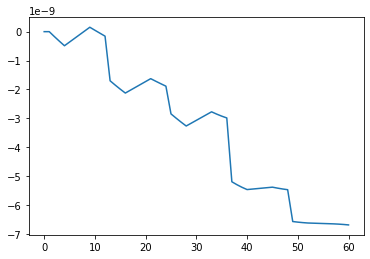

In [109]:
# plt.plot(env.sim_data[2])
# plt.plot((180/np.pi)*env.sim_data[7][0:100])
# plt.plot(env.sim_force[2])
# env.action_space_x

In [41]:
np.geomspace(0.05, 0.7, 5)

array([0.05      , 0.09671682, 0.18708287, 0.36188121, 0.7       ])